<a href="https://colab.research.google.com/github/ekaratnida/Applied-machine-learning/blob/master/Week08-workshop-2/ibm_attrition_nb_naive_bayes_log_reg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Naive Bayes and Logistic Regression with GridSearchCV on IBM Attrition Dataset
This notebook demonstrates how to train a classification model using both Naive Bayes and Logistic Regression on the same GridSearchCV pipeline. It includes:
- Data preprocessing
- Model training with `GridSearchCV`
- Performance evaluation using a confusion matrix and classification report.
- https://inseaddataanalytics.github.io/INSEADAnalytics/groupprojects/January2018FBL/IBM_Attrition_VSS.html



In [8]:
# Install necessary libraries
#!pip install pandas scikit-learn matplotlib seaborn


In [9]:
!pip install wandb

In [10]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
import seaborn as sns
import matplotlib.pyplot as plt
import wandb
import warnings
warnings.filterwarnings('ignore')

In [11]:
# Load the IBM attrition dataset
df = pd.read_csv('https://raw.githubusercontent.com/ekaratnida/Applied-machine-learning/refs/heads/master/Dataset/WA_Fn-UseC_-HR-Employee-Attrition.csv')

# Preview the data
#print(df.head())
print(df.shape)

# Convert 'Attrition' target to numerical: Yes -> 1, No -> 0
df['Attrition'] = df['Attrition'].apply(lambda x: 1 if x == 'Yes' else 0)

# Drop target from features
X = df.drop(columns=['Attrition'])
y = df['Attrition']

print(pd.value_counts(y))

# One-hot encoding for categorical variables
X = pd.get_dummies(X, drop_first=True)
#print(X.head())

# Split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y)
print(pd.value_counts(y_train))
print(pd.value_counts(y_test))
#print(X_train.shape)


(1470, 35)
Attrition
0    1233
1     237
Name: count, dtype: int64
Attrition
0    986
1    190
Name: count, dtype: int64
Attrition
0    247
1     47
Name: count, dtype: int64


In [12]:
X.columns

Index(['Age', 'DailyRate', 'DistanceFromHome', 'Education', 'EmployeeCount',
       'EmployeeNumber', 'EnvironmentSatisfaction', 'HourlyRate',
       'JobInvolvement', 'JobLevel', 'JobSatisfaction', 'MonthlyIncome',
       'MonthlyRate', 'NumCompaniesWorked', 'PercentSalaryHike',
       'PerformanceRating', 'RelationshipSatisfaction', 'StandardHours',
       'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear',
       'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole',
       'YearsSinceLastPromotion', 'YearsWithCurrManager',
       'BusinessTravel_Travel_Frequently', 'BusinessTravel_Travel_Rarely',
       'Department_Research & Development', 'Department_Sales',
       'EducationField_Life Sciences', 'EducationField_Marketing',
       'EducationField_Medical', 'EducationField_Other',
       'EducationField_Technical Degree', 'Gender_Male',
       'JobRole_Human Resources', 'JobRole_Laboratory Technician',
       'JobRole_Manager', 'JobRole_Manufacturing Director',
  

In [13]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_auc_score

# Create a pipeline with both Naive Bayes and Logistic Regression
pipe = Pipeline([
    ('model', GaussianNB())  # Placeholder, will be replaced during grid search
])

# Define the parameter grid for both models
param_grid = [
    {'model': [GaussianNB()]},  # No hyperparameters to tune for GaussianNB
    {'model': [LogisticRegression(max_iter=1000)],
     'model__C': [0.01, 0.1, 1, 10, 100],  # Regularization strength (penalty) for LogisticRegression
     'model__solver':  ['lbfgs', 'liblinear'], #,'newton-cg', 'newton-cholesky', 'sag', 'saga'],
     'model__penalty': ['l1', 'l2', 'elasticnet']
     #'model__l1_ratio': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
     }
]

# Perform GridSearchCV
grid_search = GridSearchCV(pipe, param_grid, cv=7)
grid_search.fit(X_train, y_train)

# Best model and its parameters
print(f"Best Model: {grid_search.best_estimator_}")
print(f"Best Parameters: {grid_search.best_params_}")

# Predict on the test set using the best model
y_pred = grid_search.predict(X_test)
print(y_pred)
y_pred_proba = grid_search.predict_proba(X_test)  # Probability of positive class
print(y_pred_proba)
# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Set Accuracy: {accuracy}")

# AUC
roc_auc_score = roc_auc_score(y_test, y_pred_proba[:,1])
print(f"Test Set ROC AUC: {roc_auc_score}")


Best Model: Pipeline(steps=[('model',
                 LogisticRegression(C=10, max_iter=1000, penalty='l1',
                                    solver='liblinear'))])
Best Parameters: {'model': LogisticRegression(max_iter=1000), 'model__C': 10, 'model__penalty': 'l1', 'model__solver': 'liblinear'}
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 0 1 0 0 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0
 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
[[9.32282712e-01 6.77172881e-02]
 [9.97778114e-01 2.22188575e-03]
 [8.95563216e-01 1.04436784e-01]
 [9.

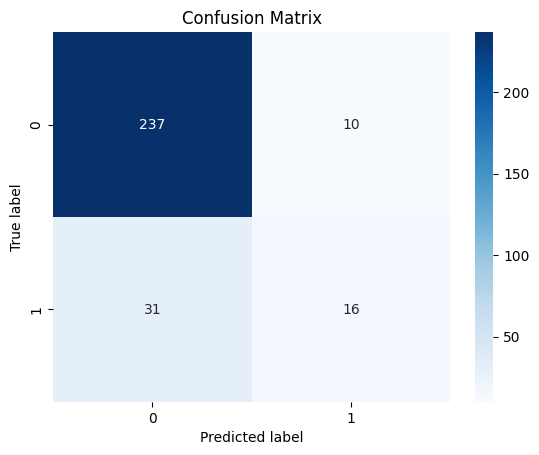

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.96      0.92       247
           1       0.62      0.34      0.44        47

    accuracy                           0.86       294
   macro avg       0.75      0.65      0.68       294
weighted avg       0.84      0.86      0.84       294



In [14]:
# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.show()

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

ROC AUC=0.808
62
[0.         0.0212766  0.23404255 0.23404255 0.25531915 0.25531915
 0.31914894 0.31914894 0.34042553 0.34042553 0.40425532 0.40425532
 0.42553191 0.42553191 0.44680851 0.44680851 0.53191489 0.53191489
 0.55319149 0.55319149 0.57446809 0.57446809 0.59574468 0.59574468
 0.61702128 0.61702128 0.63829787 0.63829787 0.65957447 0.65957447
 0.68085106 0.68085106 0.70212766 0.70212766 0.72340426 0.72340426
 0.74468085 0.74468085 0.76595745 0.76595745 0.78723404 0.78723404
 0.80851064 0.80851064 0.82978723 0.82978723 0.85106383 0.85106383
 0.87234043 0.87234043 0.89361702 0.89361702 0.91489362 0.91489362
 0.93617021 0.93617021 0.95744681 0.95744681 0.9787234  0.9787234
 1.         1.        ]


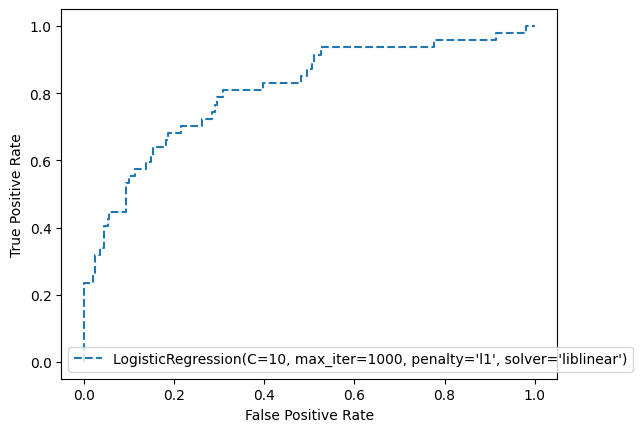

In [15]:
# roc curve and auc
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot

# calculate scores
ns_auc = roc_auc_score(y_test, y_pred_proba[:,1])

# summarize scores
print('ROC AUC=%.3f' % (ns_auc))

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, y_pred_proba[:,1])
print(len(ns_fpr))
print(ns_tpr)

# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label=grid_search.best_estimator_)

# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')

# show the legend
pyplot.legend()

# show the plot
pyplot.show()

In [16]:
wandb.login()


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: pokekarat (dads) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [17]:
run = wandb.init(project='Attritition ML', name="classification_logistic")

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


In [18]:
wandb.sklearn.plot_learning_curve(grid_search.best_estimator_, X_train, y_train)


In [19]:
wandb.sklearn.plot_classifier(grid_search.best_estimator_,
                              X_train, X_test,
                              y_train, y_test,
                              y_pred, y_pred_proba,
                              is_binary=True,
                              labels=[0, 1],
                              model_name='logistic regression') #grid_search.best_estimator_)

wandb.finish()

wandb: 
wandb: Plotting logistic regression.
wandb: WARNING could not find any of attributes feature_importances_, feature_log_prob_, coef_ on classifier. Cannot plot feature importances.
wandb: Logged feature importances.
wandb: Logged confusion matrix.
wandb: Logged summary metrics.
wandb: Logged class proportions.
wandb: Logged calibration curve.
wandb: Logged roc curve.
wandb: Logged precision-recall curve.


In [20]:
!pip install shap

In [21]:
import shap

In [22]:
explainer = shap.Explainer(
                           grid_search.best_estimator_.named_steps['model'],
                           X_train,
                           feature_names=X_train.columns.tolist()
                           )
shap_values = explainer(X_test)


200


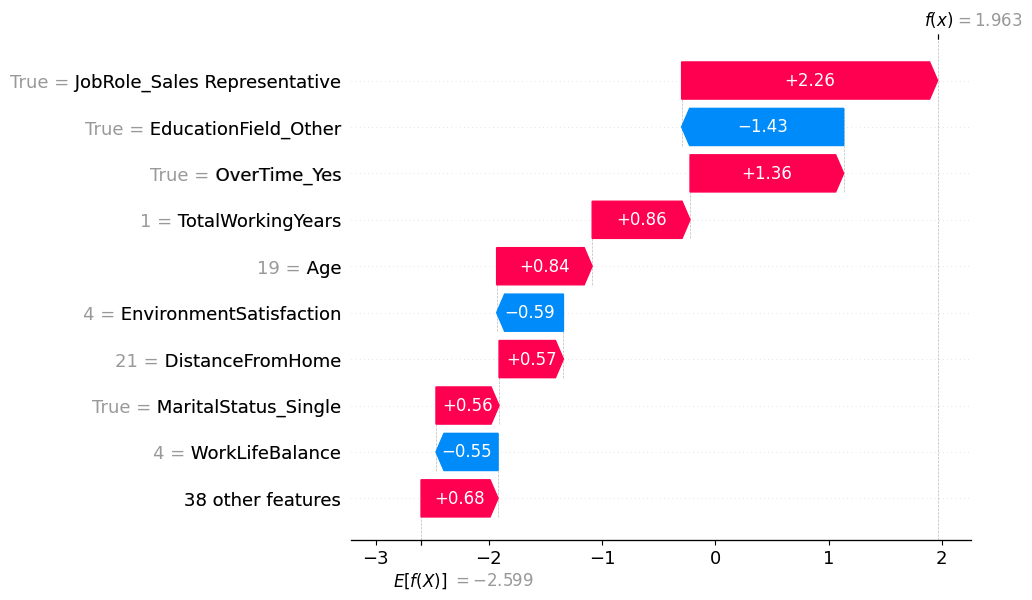

In [88]:
i = 200
print(i)
shap.plots.waterfall(shap_values[i])

In [89]:
X_test.iloc[i:i+1]

,Age,DailyRate,DistanceFromHome,Education,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,...,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Married,MaritalStatus_Single,OverTime_Yes
688,19,419,21,3,1,959,4,37,2,1,...,False,False,False,False,False,False,True,False,True,True


In [90]:
y_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0])

In [91]:
print("Actual y = ", y_test.iloc[i:i+1])
print("Predicted y = ", y_pred[i])
print(y_pred_proba[i])

Actual y =  688    1
Name: Attrition, dtype: int64
Predicted y =  1
[0.12310698 0.87689302]


In [92]:
shap.initjs()
shap.plots.force(shap_values[i])